## WGAN-GP Model TF
---

## Import modules

In [3]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from wgangp_model import WGAN_GP, load_generator, generate_synthetic_data, inverse_transform_synthetic_data
from evaluation_protocol import calculate_emd, calculate_ks_test, calculate_js_divergence, calculate_sbasic, calculate_scorr, calculate_smirr, calculate_spca

## Set dynamic GPU memory growth

In [4]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


## Load preprocessed data

In [5]:
hdf5_file_name = "datasets/newData_122500/02_dataset_preprop_train_test.hdf5"

# Open the HDF5 file
f = h5py.File(hdf5_file_name, "r")
X_train = np.array(f["X_train"])
y_train = np.array(f["y_train"])
X_test = np.array(f["X_test"])
y_test = np.array(f["y_test"])
f.close()

# Combine X_train and X_test
X_transformed = np.concatenate((X_train, X_test), axis=0)
print("Shape of X_transformed:", X_transformed.shape)
np.random.seed(42)  # Set seed for reproducibility
np.random.shuffle(X_transformed)
X_transformed

Shape of X_transformed: (122500, 16)


array([[ 0.2929293 ,  0.47474748,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.6262626 ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.47474748,  0.03030303,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.93939394,  0.27272728,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5555556 , -0.6969697 ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.25252524,  0.27272728,  0.        , ...,  0.        ,
         1.        ,  0.        ]], dtype=float32)

In [6]:
X_transformed[0]

array([0.2929293 , 0.47474748, 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

## Load Preprocessor

In [7]:
# Load the preprocessors and scalers
preprocessor_path = 'datasets/newData_122500/04_shuffle_features_scaler_MinMax(-1,1)_OneHot.pkl'
scaler_Qfwd_path = 'datasets/newData_122500/04_shuffle_Qfwd_target_MinMaxScaler_-1-1.pkl'
scaler_Qback_path = 'datasets/newData_122500/04_shuffle_Qback_target_MinMaxScaler_-1-1.pkl'

# Load the preprocessors and scalers
with open(preprocessor_path, 'rb') as f:
    preprocessor = pickle.load(f)
with open(scaler_Qfwd_path, 'rb') as f:
    scaler_Qfwd = pickle.load(f)
with open(scaler_Qback_path, 'rb') as f:
    scaler_Qback = pickle.load(f)


In [8]:
X_tensor = tf.convert_to_tensor(X_transformed, dtype=tf.float32)

# Create a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices(X_tensor)

# Define the batch size
batch_size = 30625

# Create a batched dataset
# shuffle() is optional; remove it if you want to disable shuffling
dataloader = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Example: Iterating through the DataLoader
for batch in dataloader:
    # Process your batch
    print(batch.shape)

(30625, 16)
(30625, 16)
(30625, 16)
(30625, 16)


I0000 00:00:1736253564.558233   13049 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736253564.560580   13049 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736253564.562003   13049 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736253564.668682   13049 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Train WGANGP
---

In [10]:
# Define model parameters
latent_dim = 128
N_numerical = 2  # Number of numerical input columns (excluding 2 categorical columns)
N_mat_core = len(preprocessor.named_transformers_['cat'].categories_[0])  # Number of unique categories for 'Core Material'
N_mat_shell = len(preprocessor.named_transformers_['cat'].categories_[1])  # Number of unique categories for 'Shell Material'
batch_size = 256
g_lr = 0.00005
d_lr = 0.00005
beta_1 = 0.5
beta_2 = 0.9
n_critic = 5 #cannot add more than 5, it will crash 
n_generator = 1
gradient_penalty_weight = 10
epochs = 5000
sample_interval = 500 # show results every sample_interval epochs

In [11]:
# Create and train the WGAN-GP model
wgan_gp = WGAN_GP(latent_dim, N_numerical, N_mat_core, N_mat_shell, g_lr, d_lr, beta_1, beta_2, n_critic, n_generator, gradient_penalty_weight)

/home/dsoun/env/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 1/5000 [00:05<7:14:16,  5.21s/it]

Epoch: 0, Discriminator Loss: 1.1650683879852295, Generator Loss: 0.1201692521572113


 10%|█         | 502/5000 [01:43<14:47,  5.07it/s]

Epoch: 500, Discriminator Loss: -0.675075352191925, Generator Loss: -0.8716862201690674


 20%|██        | 1002/5000 [03:21<12:22,  5.38it/s]

Epoch: 1000, Discriminator Loss: -0.2709271311759949, Generator Loss: -1.2725270986557007


 30%|███       | 1502/5000 [04:58<11:39,  5.00it/s]

Epoch: 1500, Discriminator Loss: -0.42382216453552246, Generator Loss: -0.9465771913528442


 40%|████      | 2002/5000 [06:37<09:49,  5.08it/s]

Epoch: 2000, Discriminator Loss: -0.07745775580406189, Generator Loss: -1.4112902879714966


 50%|█████     | 2502/5000 [08:14<08:10,  5.09it/s]

Epoch: 2500, Discriminator Loss: -0.24079076945781708, Generator Loss: -0.7376738786697388


 60%|██████    | 3002/5000 [09:52<06:34,  5.07it/s]

Epoch: 3000, Discriminator Loss: -0.0727899968624115, Generator Loss: -1.1344738006591797


 70%|███████   | 3502/5000 [11:28<04:46,  5.22it/s]

Epoch: 3500, Discriminator Loss: -0.3479423522949219, Generator Loss: -0.5148776769638062


 80%|████████  | 4002/5000 [13:04<03:11,  5.22it/s]

Epoch: 4000, Discriminator Loss: -0.2882095277309418, Generator Loss: -0.5895922183990479


 90%|█████████ | 4502/5000 [14:39<01:37,  5.10it/s]

Epoch: 4500, Discriminator Loss: 0.115963876247406, Generator Loss: -0.9299471974372864


100%|██████████| 5000/5000 [16:14<00:00,  5.13it/s]


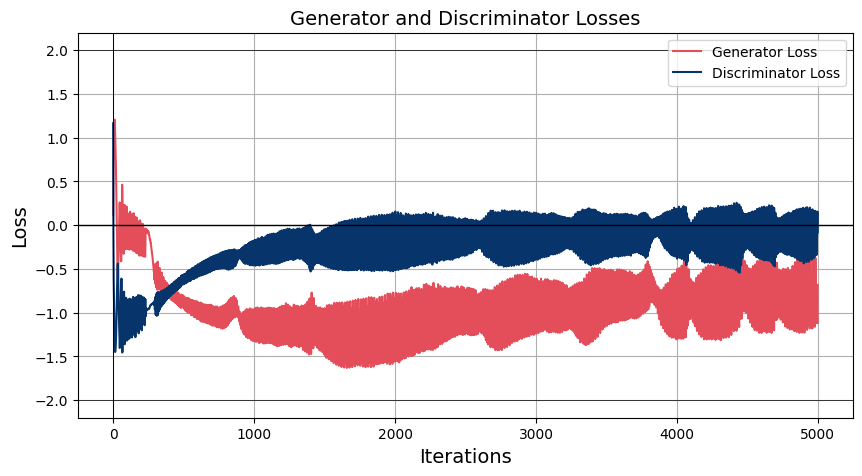

In [12]:
wgan_gp.train(X_transformed, epochs, sample_interval)

# Save the model
wgan_gp.generator.save('models/wgangp_tf/newData_122500/04_generator_tf_batch122500_noise128_weight10_5000epoch_generator.h5')   

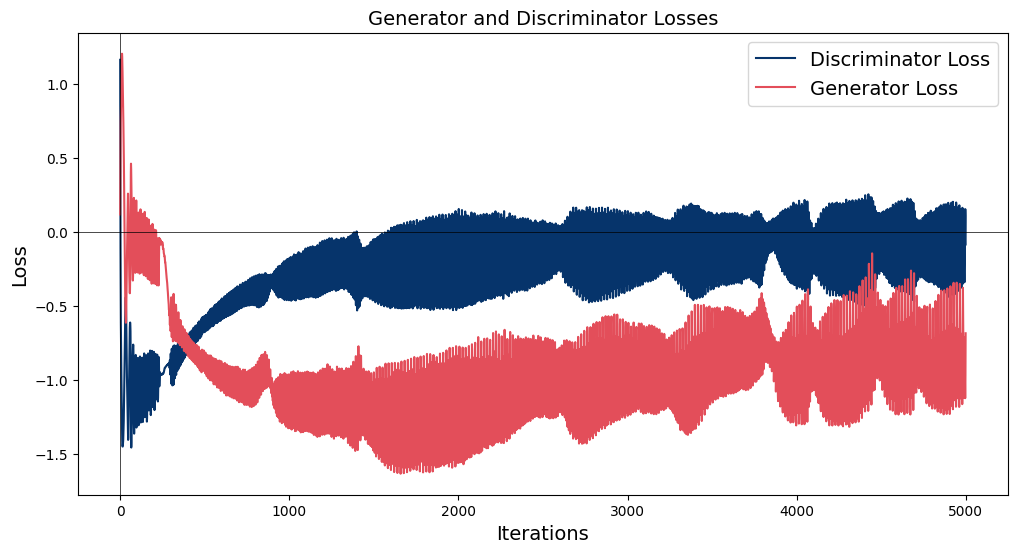

In [13]:
import pickle
import matplotlib.pyplot as plt

# Load the loss data from the pickle file
with open('models/wgangp_tf/wgangp_loss_data.pkl', 'rb') as f:
    loss_data = pickle.load(f)

# Extract generator and critic losses
generator_loss = loss_data['generator_loss']
critic_loss = loss_data['critic_loss']


# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(critic_loss, color='#06346B', label='Discriminator Loss')
plt.plot(generator_loss, color='#E34E5A', label='Generator Loss')
plt.axvline(0, color='black', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Generator and Discriminator Losses', fontsize=14)
plt.legend(fontsize=14, loc='upper right')

# Save the plot as a PDF (vector format)
# plt.savefig("save_figures/new_plot/wgangp_40000ep_10weight.svg", bbox_inches='tight', dpi=300) 

plt.show()
